### Problems need to be comfired

1. How to generate M? 
2. Given output of conv4_3 layer, how to generate M_hat?
3. Does selected feature maps indexes are fixed arcoss all imgs in a video?


probel: sel_cnn loss can not decrease
idea1: change scale factor of the mask
idea2: change data

In [1]:
import tensorflow as tf
import numpy as np
import skimage
import skimage.io
import skimage.transform

show = skimage.io.imshow
%matplotlib inline


import matplotlib.pyplot as plt
import scipy.stats as st
import os
import sys

from vgg16 import vgg16
from sel_CNN import selCNN
from input_producer import InputProducer
from utils import extract_roi, gen_mask, img_with_bbox, print_prob


In [2]:
data_path = 'data/Dog1/'
img_path = os.path.join(data_path, 'img')

# read bbox from file 
gt_fn = os.path.join(data_path, 'groundtruth_rect.txt')

input_producer = InputProducer(img_path, gt_fn)


In [3]:
img, gt, idx  = next(input_producer.gen_img)

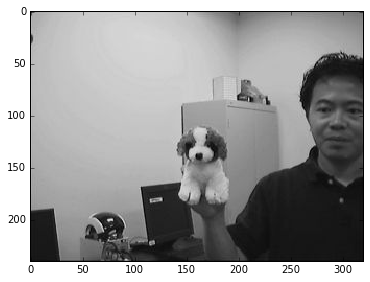

In [4]:
show(img)

/home/xlws/repos/FCNT_TF/input_producer.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [self.roi_params['roi_size'], self.roi_params['roi_size']], interp='bicubic')


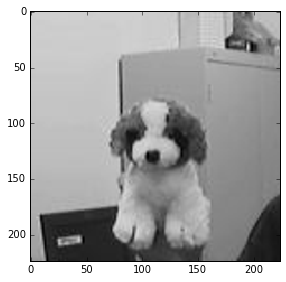

In [5]:

roi, roi_pos, preimg, pad = input_producer.extract_roi(img, gt)
#roi, _,_ =extract_roi_old(img_origin, gt_1, roi_size)
skimage.io.imshow(roi)

In [6]:
fea_sz = (28, 28)
#mask = gen_mask(img_origin.shape, fea_sz, roi_size, gt_1, [0,0], s1)
gt_M = input_producer.gen_mask(fea_sz)

0.0013186425201 max of mask
(224, 224, 3)
248 max convas


/home/xlws/repos/FCNT_TF/input_producer.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [self.roi_params['roi_size'], self.roi_params['roi_size']], interp='bicubic')


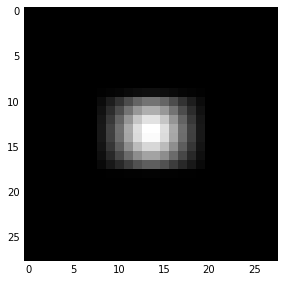

In [7]:
show(gt_M)

In [8]:

sess = tf.Session()
sess.run(tf.initialize_all_variables())
vgg = vgg16('vgg16_weights.npz', sess)

vgg.print_prob(roi, sess)


Old English sheepdog, bobtail 0.707142
Tibetan terrier, chrysanthemum dog 0.0368377
Sealyham terrier, Sealyham 0.0362287
miniature poodle 0.028478
standard poodle 0.0153578


In [9]:
vgg.img_porcessed.shape

(224, 224, 3)

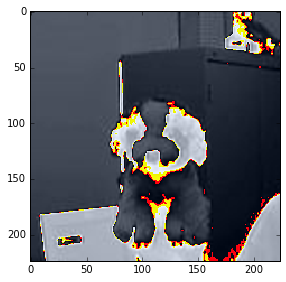

In [10]:
show(vgg.img_porcessed.astype(np.uint8))

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


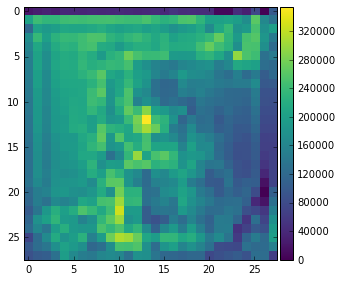

In [11]:
# visual conv layer
conv4_3 = vgg.conv4_3
conv5_3 = vgg.conv5_3
feed_dict={vgg.imgs: [roi]}
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    res4, res5 = sess.run([conv4_3, conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

In [12]:

l_selcnn = selCNN('local', conv4_3)
pre_M_tensor = l_selcnn.pre_M
train_op, losses, lr, optimizer = l_selcnn.train(gt_M)

sess = tf.Session()
sess.run(tf.initialize_all_variables())


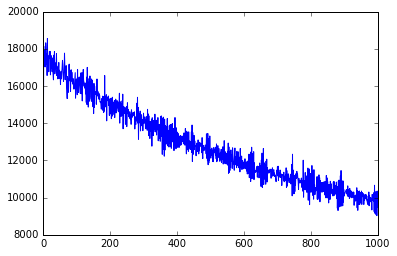

In [13]:
max_itertimes = 1000
loss = []
imgs = []
lrt = []
for i in range(max_itertimes):
    # update weights
    _, total_loss, pre_M, lr_ = sess.run([train_op, losses, pre_M_tensor, lr], feed_dict=feed_dict)
    
    # visualize predicted heat map
    sys.stdout.flush()
    #print('loss: ',total_loss)
    loss.append(total_loss)
    lrt.append(lr_)
    if i % 50==0:
        imgs.append(pre_M)
    #plt.imshow(pre_M[0,:,:,0])
plt.plot(loss)

In [14]:
loss[:10]

[10057.944,
 14106.964,
 18139.43,
 17212.594,
 17921.445,
 17212.832,
 17023.207,
 17766.438,
 18322.145,
 18033.113]

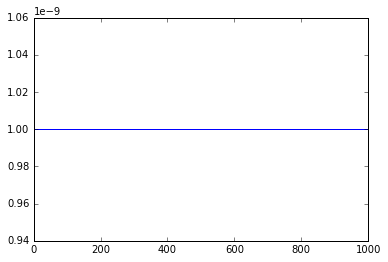

In [15]:
plt.plot(lrt)

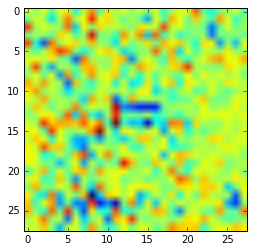

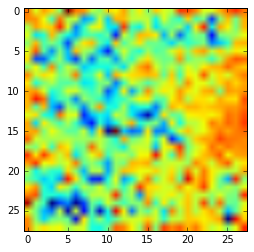

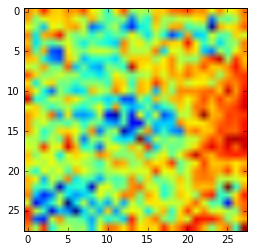

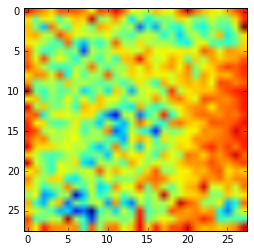

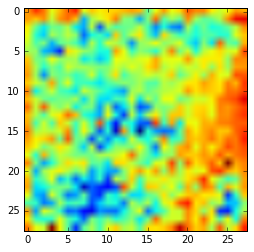

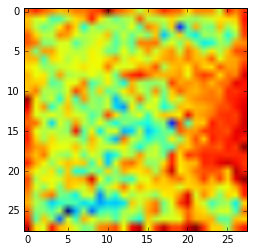

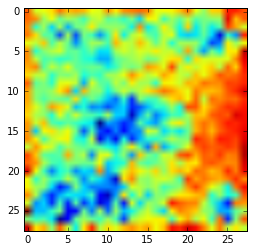

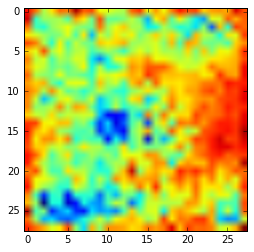

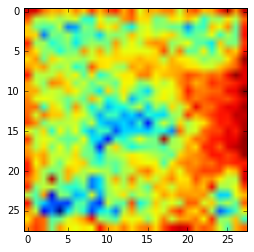

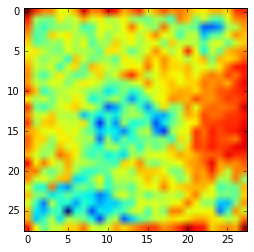

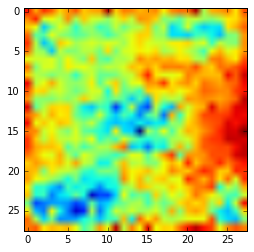

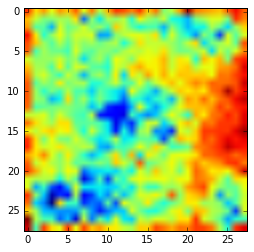

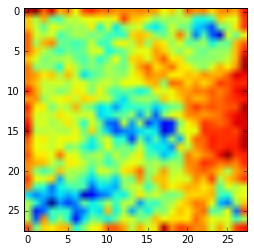

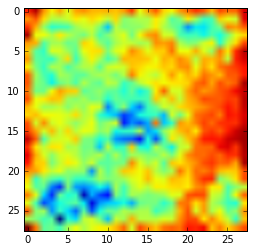

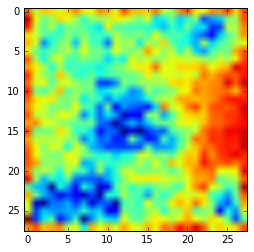

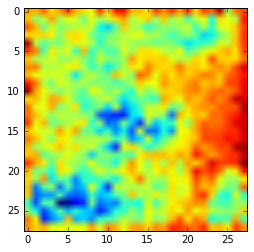

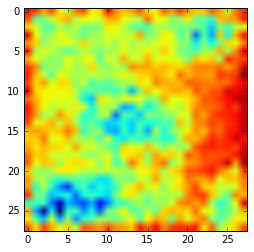

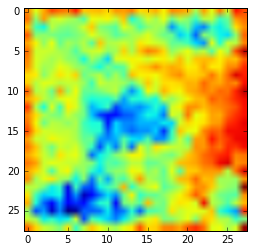

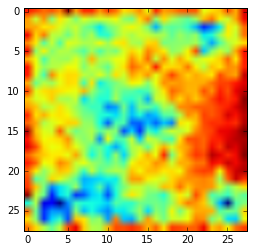

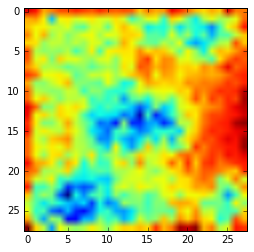

In [16]:
for img in imgs:
    plt.figure()
    plt.imshow(img[0,:,:,0])

In [17]:
loss[-1]

9484.4131

## Computes saiency maps

In [18]:
# S = -GF + 0.5 * H * F**2
# where G is partial derivative of L(sel-CNN) with respect to F feature
# maps of vgg. H is a diagnal part of the Hessian matrix, which can be 
# computed by back probpagation twice with respect to the feature maps.



In [19]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['init',
 'Placeholder',
 'vgg/preprocess/img_mean',
 'vgg/preprocess/sub',
 'vgg/conv1_1/truncated_normal/shape',
 'vgg/conv1_1/truncated_normal/mean',
 'vgg/conv1_1/truncated_normal/stddev',
 'vgg/conv1_1/truncated_normal/TruncatedNormal',
 'vgg/conv1_1/truncated_normal/mul',
 'vgg/conv1_1/truncated_normal',
 'vgg/conv1_1/weights',
 'vgg/conv1_1/weights/Assign',
 'vgg/conv1_1/weights/read',
 'vgg/conv1_1/Conv2D',
 'vgg/conv1_1/Const',
 'vgg/conv1_1/biases',
 'vgg/conv1_1/biases/Assign',
 'vgg/conv1_1/biases/read',
 'vgg/conv1_1/BiasAdd',
 'vgg/conv1_1',
 'vgg/conv1_2/truncated_normal/shape',
 'vgg/conv1_2/truncated_normal/mean',
 'vgg/conv1_2/truncated_normal/stddev',
 'vgg/conv1_2/truncated_normal/TruncatedNormal',
 'vgg/conv1_2/truncated_normal/mul',
 'vgg/conv1_2/truncated_normal',
 'vgg/conv1_2/weights',
 'vgg/conv1_2/weights/Assign',
 'vgg/conv1_2/weights/read',
 'vgg/conv1_2/Conv2D',
 'vgg/conv1_2/Const',
 'vgg/conv1_2/biases',
 'vgg/conv1_2/biases/Assign',
 'vgg/conv1_2/biases

In [20]:
F = vgg.kernel4_3
G = optimizer.compute_gradients(losses, var_list=[F])

In [21]:
G

[(<tf.Tensor 'gradients/vgg/conv4_3/Conv2D_grad/tuple/control_dependency_1:0' shape=(3, 3, 512, 512) dtype=float32>,
  <tensorflow.python.ops.variables.Variable at 0x7f592c4afa90>)]